In [27]:
%matplotlib inline

import sys
import time
import itertools

import gym
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D

mpl.style.use('ggplot')

# if "../" not in sys.path:
#   sys.path.append("../") 

import sklearn.pipeline
import sklearn.preprocessing
from sklearn.linear_model import SGDRegressor
from sklearn.kernel_approximation import RBFSampler

In [2]:
# load environment
env = gym.envs.make("MountainCar-v0")

## learn about the environment

In [3]:
# observation (state) is (position, velocity)
print(env.action_space)
print(env.observation_space)
print(env.observation_space.high)
print(env.observation_space.low)
print(env.observation_space.bounded_above)
print(env.observation_space.bounded_below)

Discrete(3)
Box(2,)
[0.6  0.07]
[-1.2  -0.07]
[ True  True]
[ True  True]


In [4]:
space = gym.spaces.Discrete(3)
x = space.sample()
print(space.contains(x))
print(space.n == 3)

True
True


In [5]:
# test the interaction with the environment
env.reset()
for i in range(200):
    env.render()
    action = env.action_space.sample()
    observation, reward, done, info = env.step(action)
    print("\r({}, {}, {}, {})".format(observation, reward, done, info), end="")
    time.sleep(0.01)
    
    if done:
        env.reset()


([-0.48907497  0.00669356], -1.0, True, {'TimeLimit.truncated': True})

## Feature Selection

In [6]:
# Feature Preprocessing: Normalize to zero mean and unit variance
# We use a few samples from the observation space to do this
observation_examples = np.array([env.observation_space.sample() for x in range(10000)])
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(observation_examples)

# Used to convert a state to a featurizes represenation.
# We use RBF kernels with different variances to cover different parts of the space
featurizer = sklearn.pipeline.FeatureUnion([
        ("rbf1", RBFSampler(gamma=5.0, n_components=100)),
        ("rbf2", RBFSampler(gamma=2.0, n_components=100)),
        ("rbf3", RBFSampler(gamma=1.0, n_components=100)),
        ("rbf4", RBFSampler(gamma=0.5, n_components=100))
        ])
featurizer.fit(scaler.transform(observation_examples))

FeatureUnion(n_jobs=None,
             transformer_list=[('rbf1',
                                RBFSampler(gamma=5.0, n_components=100,
                                           random_state=None)),
                               ('rbf2',
                                RBFSampler(gamma=2.0, n_components=100,
                                           random_state=None)),
                               ('rbf3',
                                RBFSampler(gamma=1.0, n_components=100,
                                           random_state=None)),
                               ('rbf4',
                                RBFSampler(gamma=0.5, n_components=100,
                                           random_state=None))],
             transformer_weights=None, verbose=False)

## Value Function Approximation

In [7]:
class Estimator():
    """
    Value Function approximator. 
    """
    
    def __init__(self):
        # We create a separate model for each action in the environment's
        # action space. Alternatively we could somehow encode the action
        # into the features, but this way it's easier to code up.
        self.models = []
        for _ in range(env.action_space.n):
            model = SGDRegressor(learning_rate="constant")
            # We need to call partial_fit once to initialize the model
            # or we get a NotFittedError when trying to make a prediction
            # This is quite hacky.
            model.partial_fit([self.featurize_state(env.reset())], [0])
            self.models.append(model)
    
    def featurize_state(self, state):
        """
        Returns the featurized representation for a state.
        """
        scaled = scaler.transform([state])
        featurized = featurizer.transform(scaled)
        return featurized[0]
    
    def predict(self, s, a=None):
        """
        Makes value function predictions.
        
        Args:
            s: state to make a prediction for
            a: (Optional) action to make a prediction for
            
        Returns
            If an action a is given this returns a single number as the prediction.
            If no action is given this returns a vector or predictions for all actions
            in the environment where pred[i] is the prediction for action i.
            
        """
        features = self.featurize_state(s)
        if not a:
            return np.array([m.predict([features])[0] for m in self.models])
        else:
            return self.models[a].predict([features])[0]
    
    def update(self, s, a, y):
        """
        Updates the estimator parameters for a given state and action towards
        the target y.
        """
        features = self.featurize_state(s)
        self.models[a].partial_fit([features], [y])

## Off-Policy Control with Q-Learning using Value Function Approximation

In [8]:
# behavior policy: epsilon-greedy
def behaviorPolicyEpsilonGreedy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action. Float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    """
    def policyFn(observation):
        A_probs = np.ones(nA, dtype=float) * epsilon / nA
        best_action = np.argmax(Q[observation])
        A_probs[best_action] += (1.0 - epsilon)
        return A_probs
    return policyFn

In [11]:
# Off-policy control with Q-Learning
class Stats:
    def __init__(self, num_episodes):
        self.reset(num_episodes)
    def reset(self, num_episodes):
        self.episode_lengths = np.zeros(num_episodes)
        self.episode_rewards = np.zeros(num_episodes)

def qLearning(env, estimator, num_episodes, discount_factor=1.0, epsilon=0.1, epsilon_decay=1.0):
    """
    Q-Learning algorithm for fff-policy TD control using Function Approximation.
    Finds the optimal greedy policy while following an epsilon-greedy policy.
    
    Args:
        env: OpenAI environment.
        estimator: Action-Value function estimator
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
        epsilon_decay: Each episode, epsilon is decayed by this factor
    
    Returns:
        An EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """

    # Keeps track of useful statistics
    stats = Stats(num_episodes)    
    
    for i_episode in range(num_episodes):
        
        # The policy we're following
        policy = behaviorPolicyEpsilonGreedy(
            estimator, epsilon * epsilon_decay**i_episode, env.action_space.n)
        
        # Print out which episode we're on, useful for debugging.
        # Also print reward for last episode
        last_reward = stats.episode_rewards[i_episode - 1]
        sys.stdout.flush()
        
        # Reset the environment and pick the first action
        state = env.reset()
        
        # Only used for SARSA, not Q-Learning
        next_action = None
        
        # One step in the environment
        for t in itertools.count():
                        
            # Choose an action to take
            # If we're using SARSA we already decided in the previous step
            if next_action is None:
                action_probs = policy(state)
                action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
            else:
                action = next_action
            
            # Take a step
            next_state, reward, done, info = env.step(action)
    
            # Update statistics
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t
            
            # TD Update
            q_values_next = estimator.predict(next_state)
            
            # Use this code for Q-Learning
            # Q-Value TD Target
            td_target = reward + discount_factor * np.max(q_values_next)
            
            # Use this code for SARSA TD Target for on policy-training:
            # next_action_probs = policy(next_state)
            # next_action = np.random.choice(np.arange(len(next_action_probs)), p=next_action_probs)             
            # td_target = reward + discount_factor * q_values_next[next_action]
            
            # Update the function approximator using our target
            estimator.update(state, action, td_target)
            
            print("\rStep {} @ Episode {}/{} ({})".format(t, i_episode + 1, num_episodes, last_reward), end="")
                
            if done:
                break
                
            state = next_state
    
    return stats

In [13]:
estimator = Estimator()
# Note: For the Mountain Car we don't actually need an epsilon > 0.0
# because our initial estimate for all states is too "optimistic" which leads
# to the exploration of all states.
stats = qLearning(env, estimator, 100, epsilon=0.0)

Step 154 @ Episode 100/100 (-132.0)

## Act using Learned Q Value Function

In [25]:
# Act using Learned Q Value Function
iter_num = 1
for i_episode in range(iter_num):
    observation = env.reset() # observation here is state ID.
    print(observation)
    count = 0
    while True:
        count += 1
        env.render() # plot the current state of the env
        action = np.argmax(estimator.predict(observation))
        observation, reward, done, info = env.step(action)
        print(observation, reward, done, info)
        time.sleep(0.02)
        if done:
            env.render()
            print("Episode {}/{} finished after {} timesteps".format(i_episode+1, iter_num, count))
            break

[-0.54894299  0.        ]
[-0.54975309 -0.0008101 ] -1.0 False {}
[-0.55136723 -0.00161415] -1.0 False {}
[-0.55377336 -0.00240612] -1.0 False {}
[-0.55695348 -0.00318012] -1.0 False {}
[-0.56088386 -0.00393038] -1.0 False {}
[-0.56553518 -0.00465132] -1.0 False {}
[-0.57087281 -0.00533763] -1.0 False {}
[-0.57685707 -0.00598426] -1.0 False {}
[-0.5834436  -0.00658652] -1.0 False {}
[-0.59058369 -0.00714009] -1.0 False {}
[-0.59822477 -0.00764108] -1.0 False {}
[-0.60631082 -0.00808605] -1.0 False {}
[-0.61478288 -0.00847206] -1.0 False {}
[-0.62357955 -0.00879667] -1.0 False {}
[-0.63263756 -0.00905801] -1.0 False {}
[-0.64189228 -0.00925473] -1.0 False {}
[-0.65127831 -0.00938603] -1.0 False {}
[-0.66072999 -0.00945168] -1.0 False {}
[-0.67018195 -0.00945196] -1.0 False {}
[-0.67956963 -0.00938768] -1.0 False {}
[-0.68882975 -0.00926012] -1.0 False {}
[-0.69790076 -0.00907101] -1.0 False {}
[-0.70672328 -0.00882251] -1.0 False {}
[-0.71524041 -0.00851713] -1.0 False {}
[-0.72339811 -

## Plot

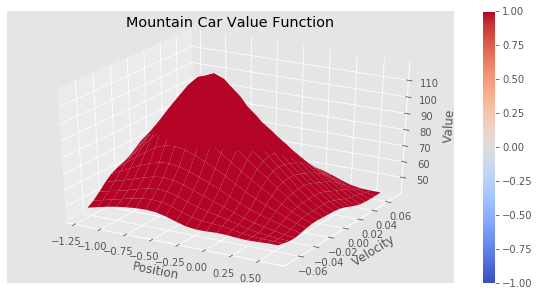

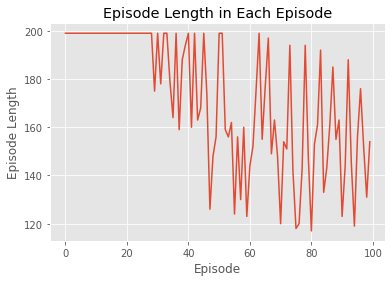

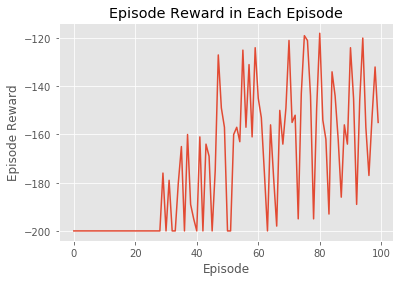

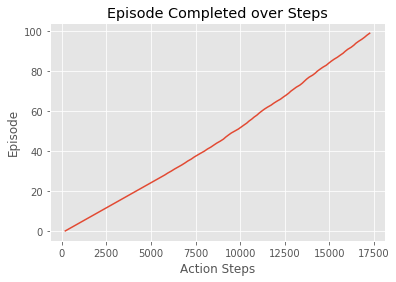

In [28]:
def plotValueFunction(env, estimator, num_tiles=20):
    x = np.linspace(env.observation_space.low[0], env.observation_space.high[0], num=num_tiles)
    y = np.linspace(env.observation_space.low[1], env.observation_space.high[1], num=num_tiles)
    X, Y = np.meshgrid(x, y)
    Z = np.apply_along_axis(lambda _: -np.max(estimator.predict(_)), 2, np.dstack([X, Y]))

    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(111, projection="3d")
    surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                           cmap=mpl.cm.coolwarm, vmin=-1.0, vmax=1.0)
    ax.set_xlabel('Position')
    ax.set_ylabel('Velocity')
    ax.set_zlabel('Value')
    ax.set_title("Mountain Car Value Function")
    fig.colorbar(surf)
    plt.show(fig)
def plotEpisodeLength(stats, figuresize=(8,6), noshow=False):
    # Plot the episode length over time
    fig = plt.figure()
    plt.plot(stats.episode_lengths)
    plt.xlabel("Episode")
    plt.ylabel("Episode Length")
    plt.title("Episode Length in Each Episode")
    if noshow:
        plt.close(fig)
    else:
        plt.show(fig)
        
def plotReward(stats, figuresize=(8,6), noshow=False):
    # Plot the episode length over time
    fig = plt.figure()
    plt.plot(stats.episode_rewards)
    plt.xlabel("Episode")
    plt.ylabel("Episode Reward")
    plt.title("Episode Reward in Each Episode")
    if noshow:
        plt.close(fig)
    else:
        plt.show(fig)
        
def plotEpisodeNumOverSteps(stats, figuresize=(8,6), noshow=False):
    # Plot time steps and episode number
    fig = plt.figure()
    plt.plot(np.cumsum(stats.episode_lengths), np.arange(len(stats.episode_lengths)))
    plt.xlabel("Action Steps")
    plt.ylabel("Episode")
    plt.title("Episode Completed over Steps")
    if noshow:
        plt.close(fig)
    else:
        plt.show(fig)

plotValueFunction(env, estimator)
plotEpisodeLength(stats)
plotReward(stats)
plotEpisodeNumOverSteps(stats)